### Analyzing processed prompt sample

In [181]:
import pandas as pd
import numpy as np
import json
from datetime import datetime
from tqdm import tqdm
import orjson
import matplotlib.pyplot as plt
import re

AVAILABLE_TAGS = [
    "multiple_choice",
    "context_based",
    "knowledge_based",
    "human_eval",
    "code"
]

In [1]:
from transformers.hf_api import HfApi

HfApi().delete_repo("models--Qwen--Qwen-1_8B-Chat")

ModuleNotFoundError: No module named 'transformers.hf_api'

In [182]:
dataset_path = '../../../../Downloads/78078167-ad93-4ed6-955f-d139574f5396'
pd.read_json(dataset_path).head()

,instruction,answer,id
0,"[{'role': 'system', 'content': '### Task Your ...","{\n ""specificity"": 1,\n ""domain_knowledg...",6.751745e+12
1,"[{'role': 'system', 'content': '### Task Your ...","{\n ""specificity"": 2,\n ""domain_knowledg...",1.321561e+28
2,"[{'role': 'system', 'content': '### Task Your ...","{\n ""specificity"": 2,\n ""domain_knowledg...",4.041745e+12
3,"[{'role': 'system', 'content': '### Task Your ...","{\n ""specificity"": 2,\n ""domain_knowledg...",8.572158e+28
4,"[{'role': 'system', 'content': '### Task Your ...","{\n ""specificity"": 2,\n ""domain_knowledg...",-8.343583e+27


In [183]:
def parse_json_safely(answer):
    # Step 1: Remove non-JSON prefixes (e.g., "--- Output:")
    json_str = re.sub(r'^.*?(\{.*\})', r'\1', answer, flags=re.DOTALL)    
    # Step 2: Fix unescaped backslashes (e.g., "\sim" → "\\sim")
    json_str = re.sub(r'(?<!\\)\\([^"\\/bfnrtu])', r'\\\\\1', json_str)
    
    try:
        return json.loads(json_str)
    except json.JSONDecodeError as e:
        print(f"Failed to parse JSON (even after cleanup): {e} for answer: {answer}")
    return np.nan

def extract_prompt(instruction):
    try:
        start = instruction[1]['content'].find('"prompt":') + len('"prompt":')
        end = instruction[1]['content'].rfind('\n\n}')
        return instruction[1]['content'][start:end].strip()
    except Exception:
        print(f"Extraction prompt failed: {instruction[1]['content']}")
        return np.nan

processed_df = pd.read_json(dataset_path)
# processed_df["prompt"] = processed_df["instruction"].apply(extract_prompt)
processed_df.drop(columns=['instruction'], inplace=True)
processed_df["id"] = processed_df["id"].astype(float).round(3)
processed_df["answer"] = processed_df["answer"].apply(parse_json_safely)
processed_df["row-id"] = processed_df.index
processed_df.head()

,answer,id,row-id
0,"{'specificity': 1, 'domain_knowledge': 5, 'com...",6.751745e+12,0
1,"{'specificity': 2, 'domain_knowledge': 3, 'com...",1.321561e+28,1
2,"{'specificity': 2, 'domain_knowledge': 3, 'com...",4.041745e+12,2
3,"{'specificity': 2, 'domain_knowledge': 2, 'com...",8.572158e+28,3
4,"{'specificity': 2, 'domain_knowledge': 3, 'com...",-8.343583e+27,4


In [184]:
with open("./final_dataset.json", "rb") as f:
    final_dataset = pd.DataFrame(orjson.loads(f.read()))
final_dataset["id"] = (final_dataset["question_id"].astype(str) + final_dataset["tstamp"].astype(str)).astype(float).round(3)
final_dataset["prompt"] = final_dataset["conversation_a"].apply(lambda x: x[0]['content'].strip())
final_dataset["default_answer"] = final_dataset["conversation_a"].apply(lambda x: np.nan if len(x) == 1 else x[1]['content'])
final_dataset.drop(columns=["question_id", "tstamp", "conversation_a"], inplace=True)
final_dataset.head()

,tag,source,meta_info,id,prompt,default_answer
0,multiple_choice,allenai/ai2_arc,{'id_in_dataset': 'Mercury_7135345'},6.751745e+12,Two processes are involved in the formation of...,wind erosion then deposition
1,knowledge_based,khaimaitien/qa-expert-multi-hop-qa-V1.0,"{'tag': 'long_attributes-train.json', 'src': '...",1.321561e+28,Is the Colegio Nacional de Buenos Aires locate...,"Yes, the Colegio Nacional de Buenos Aires is l..."
2,multiple_choice,allenai/ai2_arc,{'id_in_dataset': 'OHAT_2009_5_9'},4.041745e+12,Earthworms live underground in the soil. As th...,Earthworm tunnels loosen the soil so plant roo...
3,physical_reasoning,ybisk/piqa,None,8.572158e+28,How can I temporarily seal a broken window?,Tape a sheet of heavy plastic over the hole.
4,knowledge_based,khaimaitien/qa-expert-multi-hop-qa-V1.0,"{'tag': 'entities-single_neg_valid.json', 'src...",-8.343583e+27,What position does Jungkook hold in his group ...,"Based on the provided knowledge, it is unclear..."


In [185]:
answer_df = pd.DataFrame()
for key in list(processed_df["answer"][0].keys()):
    answer_df[key] = processed_df["answer"].apply(lambda answer: answer.get(key, np.nan))
for key in ['tag', 'source', 'meta_info', 'prompt', 'default_answer']:
    answer_df[key] = final_dataset[key]
answer_df["model_answer"] = processed_df["answer"].apply(lambda answer: answer.get("answer", np.nan))
answer_df["row-id"] = processed_df["row-id"]
print(f"Final table has {answer_df.shape[0]} rows")
answer_df.info()

Final table has 5200 rows
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200 entries, 0 to 5199
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   specificity         5200 non-null   int64 
 1   domain_knowledge    5200 non-null   int64 
 2   complexity          5200 non-null   int64 
 3   problem_solving     5200 non-null   int64 
 4   creativity          5200 non-null   int64 
 5   technical_accuracy  5200 non-null   int64 
 6   real_world          5200 non-null   int64 
 7   context_complete    5200 non-null   int64 
 8   answer              5200 non-null   object
 9   tag                 5200 non-null   object
 10  source              5200 non-null   object
 11  meta_info           4000 non-null   object
 12  prompt              5200 non-null   object
 13  default_answer      4042 non-null   object
 14  model_answer        5200 non-null   object
 15  row-id              5200 non-null   int64 
dty

In [40]:
import plotly.express as px
from ipywidgets import interact, widgets

# Create interactive visualization
def plot_distribution(column):
    fig = px.histogram(
        answer_df[['specificity', 'domain_knowledge', 'complexity', 'problem_solving',
       'creativity', 'technical_accuracy', 'real_world', 'context_complete']], 
        x=column,
        nbins=5,
        title=f'Distribution of {column}',
        labels={'x': 'Score', 'y': 'Count'},
        color_discrete_sequence=['#636EFA'],
        category_orders={column: [1, 2, 3, 4, 5]}
    )

    # Customize layout
    fig.update_layout(
        xaxis=dict(tickmode='array', tickvals=[1, 2, 3, 4, 5]),
        bargap=0.1,
        showlegend=False
    )
    
    fig.show()

# Create dropdown widget
column_dropdown = widgets.Dropdown(
    options=['specificity', 'domain_knowledge', 'complexity', 'problem_solving',
       'creativity', 'technical_accuracy', 'real_world', 'context_complete'],
    value='specificity',
    description='Metric:',
    style={'description_width': 'initial'}
)

# Display interactive widget
interact(plot_distribution, column=column_dropdown)

interactive(children=(Dropdown(description='Metric:', options=('specificity', 'domain_knowledge', 'complexity'…

<function __main__.plot_distribution(column)>

In [128]:
from textwrap import shorten

def format_text(text, max_length=400):
    """Shorten text and add ellipsis if needed"""
    if pd.isna(text):
        return "None"
    return shorten(str(text), width=max_length, placeholder="...")

def print_top_prompt_answer_pairs(df, column):
    top_df = df[df[column] == 5].head(5)
    
    if top_df.empty:
        print(f"\n🔍 No top entries found for {column} (score 5)")
        return
    
    print(f"\n{'='*80}")
    print(f"🌟 TOP 5 PROMPT-ANSWER PAIRS FOR: {column.upper()}")
    print(f"{'='*80}\n")
    
    for idx, row in top_df.iterrows():
        output = {
            'Metadata': {
                'Tag': row.get('tag', 'None'),
                'Source': row.get('source', 'None'),
                'Meta Info': format_text(row.get('meta_info')), 
            },
            'Prompt': format_text(row['prompt']),
            'Answers': {
                'Default': format_text(row.get('default_answer')),
                'Model': format_text(row.get('model_answer')),
                # 'Reference': format_text(row.get('answer'))
            },
            'Scores': {
                col: row[col] 
                for col in ['specificity', 'domain_knowledge', 'complexity', 
                          'problem_solving', 'creativity', 'technical_accuracy',
                          'real_world', 'context_complete']
            }
        }

        print(f"📌 Entry #{idx}")
        print(f"🏷  Tag: {output['Metadata']['Tag']}")
        print(f"📚 Source: {output['Metadata']['Source']}")
        print(f"ℹ️  Meta: {output['Metadata']['Meta Info']}\n")
        
        print(f"❓ PROMPT:\n{output['Prompt']}\n")
        print("💬 ANSWERS:")
        print(f"• Default: {output['Answers']['Default']}")
        print(f"• Model: {output['Answers']['Model']}")
        # print(f"• Reference: {output['Answers']['Reference']}\n")
        
        print("⭐ SCORES:")
        scores = ", ".join([f"{k}: {v}" for k, v in output['Scores'].items()])
        print(f"{scores}\n")
        print(f"{'-'*60}\n")

for col_name in ['specificity', 'domain_knowledge', 'complexity', 
                'problem_solving', 'creativity', 'technical_accuracy',
                'real_world', 'context_complete']:
    print_top_prompt_answer_pairs(answer_df, col_name)


🌟 TOP 5 PROMPT-ANSWER PAIRS FOR: SPECIFICITY

📌 Entry #205
🏷  Tag: knowledge_based
📚 Source: allenai/tulu-3-sft-mixture
ℹ️  Meta: {'id_in_dataset': 'ai2-adapt-dev/flan_v2_converted_765', 'original_dataset': 'ai2-adapt-dev/flan_v2_converted', 'question_length': 1176}

❓ PROMPT:
Detailed Instructions: A text is given in Oriya. Translate it from the Oriya language to the Urdu language. The translation must not omit or add information to the original sentence. See one example below: Problem: اسکیم کے لئے اگلے تین برسوں کے لئے 10774 کروڑ روپے مختص کئے گئے ہیں۔ تمام چھوٹے اور حاشئے پر رہنے والے کسان ، جن کی عمر 18 سے 40 برس تک ہے، اس اسکیم کے لئے درخواست دے سکتے ہیں۔...

💬 ANSWERS:
• Default: ଏହି ପଖୱାଡା ପାଳନର ନିର୍ଦ୍ଦେଶାବଳୀ ଭାରତୀୟ ରେଳବାଇର ସମ୍ପୂର୍ଣ୍ଣ ନେଟୱର୍କରେ ବଣ୍ଟନ କରାଯାଇଛି । ଏହି ପଖୱାଡା ପାଳନକୁ ସମ୍ପୂର୍ଣ୍ଣ ସଫଳ କରିବା ସହ ବିଶେଷ କରି ରେଳ ଷ୍ଟେସନ ଓ ଟ୍ରେନ ଗୁଡ଼ିକରେ ସ୍ୱଚ୍ଛତା ଅବଲମ୍ବନ କରିବାକୁ ରେଳ ଓ କୋଇଲା ମନ୍ତ୍ରୀ ପୀୟୁଷ ଗୋୟଲ ରେଲୱେ ପ୍ରଶାସନକୁ ନିର୍ଦ୍ଦେଶ ଦେଇଛନ୍ତି । ରେଳବାଇର ଅଫିସର ଓ କର୍ମଚାରୀମାନେ ତଥା ସମସ୍ତ ବିଭାଗ ଏ

In [131]:
import plotly.express as px
from ipywidgets import interact, widgets

def plot_distribution(column, tag):
    tagged_df = answer_df[answer_df['tag'] == tag]
    fig = px.histogram(
        answer_df, 
        x=column,
        nbins=5,
        title=f'Distribution of {column} (All tags vs {tag})',
        labels={'x': 'Score', 'y': 'Count'},
        color_discrete_sequence=['#FFA15A'],  # Orange for all tags
        opacity=0.5,
        category_orders={column: [1, 2, 3, 4, 5]}
    )

    fig.add_trace(
        px.histogram(
            tagged_df,
            x=column,
            nbins=5,
            color_discrete_sequence=['#636EFA']  # Blue for selected tag
        ).data[0]
    )

    fig.update_layout(
        xaxis=dict(tickmode='array', tickvals=[1, 2, 3, 4, 5]),
        bargap=0.1,
        width=600,
        height=600,
        barmode='overlay',
        showlegend=True,
        legend_title_text='Dataset',
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )

    fig.data[0].name = 'All tags'
    fig.data[1].name = f'Tag: {tag}'

    fig.show()

column_dropdown = widgets.Dropdown(
    options=['specificity', 'domain_knowledge', 'complexity', 'problem_solving',
             'creativity', 'technical_accuracy', 'real_world', 'context_complete'],
    value='specificity',
    description='Metric:',
    style={'description_width': 'initial'}
)

tag_dropdown = widgets.Dropdown(
    options=['multiple_choice', 'knowledge_based', 'physical_reasoning', 'context_based'],
    value='multiple_choice',
    description='Tag:',
    style={'description_width': 'initial'}
)

interact(plot_distribution, column=column_dropdown, tag=tag_dropdown)

interactive(children=(Dropdown(description='Metric:', options=('specificity', 'domain_knowledge', 'complexity'…

<function __main__.plot_distribution(column, tag)>

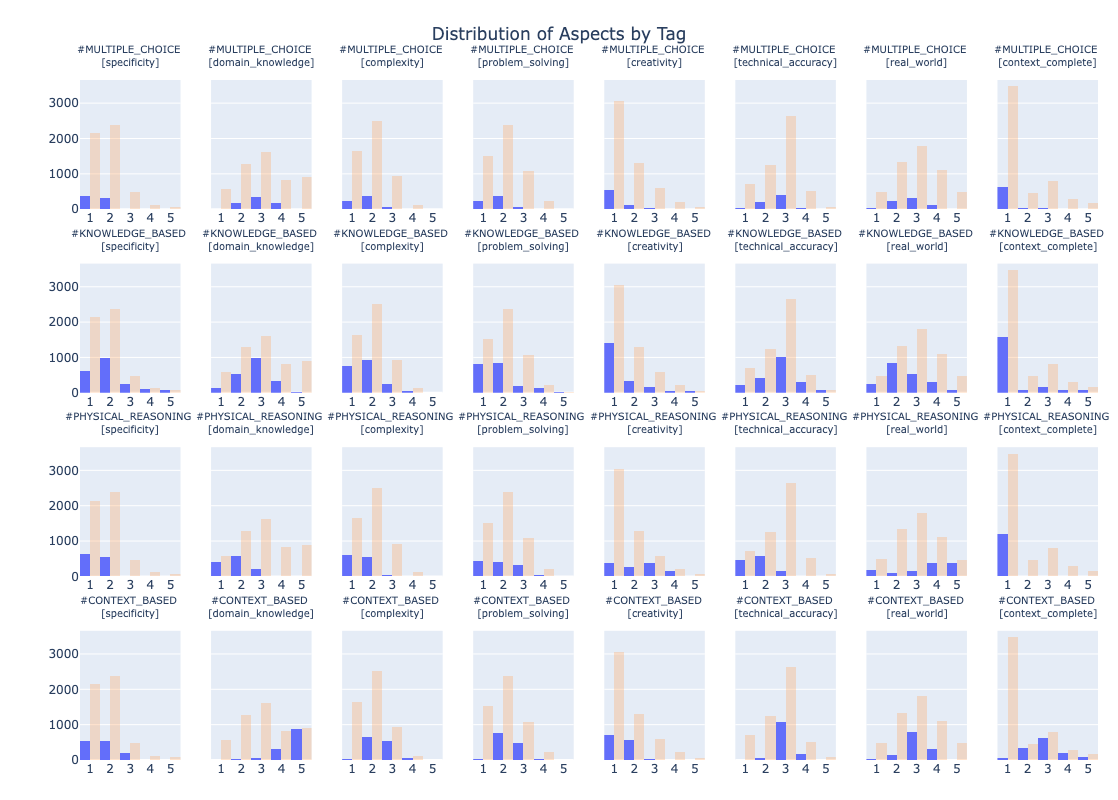

In [ ]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

aspects = ['specificity', 'domain_knowledge', 'complexity', 'problem_solving',
           'creativity', 'technical_accuracy', 'real_world', 'context_complete']
tags = ['multiple_choice', 'knowledge_based', 'physical_reasoning', 'context_based']

subplot_titles = [f"#{tag.upper()}\n<br>[{aspect}]" for i, tag in enumerate(tags) for aspect in aspects ]

fig = make_subplots(
    rows=len(tags), 
    cols=len(aspects),
    shared_yaxes=True,
    subplot_titles=subplot_titles,
    horizontal_spacing=0.03,
    vertical_spacing=0.08
)

for row_idx, tag in enumerate(tags, 1):
    for col_idx, aspect in enumerate(aspects, 1):
        tagged_df = answer_df[answer_df['tag'] == tag]

        hist = px.histogram(
            tagged_df,
            x=aspect,
            nbins=5,
            title = f"#{tag}",
            color_discrete_sequence=['#636EFA']
        )
        fig.add_trace(hist.data[0], row=row_idx, col=col_idx)

        overall_hist = px.histogram(
            answer_df,
            x=aspect,
            nbins=5,
            title = f"#{tag}",
            color_discrete_sequence=['#FFA15A'],
            opacity=0.3
        )
        fig.add_trace(overall_hist.data[0], row=row_idx, col=col_idx)

        fig.update_xaxes(
            tickmode='array',
            tickvals=[1, 2, 3, 4, 5],
            row=row_idx, 
            col=col_idx,
            # showticklabels=(row_idx == len(tags))  # Only show x-axis labels on bottom row
        )

        fig.update_yaxes(
            showticklabels=(col_idx == 1),  # Only show y-axis labels on first column
            row=row_idx,
            col=col_idx
        )

fig.update_layout(
    height=200 * len(tags),
    width=200 * len(aspects),
    showlegend=False,
    title_text="Distribution of Aspects by Tag",
    title_x=0.5,
    margin=dict(l=80, r=20, t=80, b=40),
    bargap=0
)

fig.update_annotations(
    font_size=10,
    yshift=10
)

fig.show()

### Conclusions of analysis
- It can be noted that context-based prompt takes most of the high domain_knowledge, low specificity, low creativity, high technical accuracy, middle real_world
- Complexity is relatively low, but not for context. Since we don't want to deal with too difficult ones, let's take < 4
- Real world is often around 3, let's take >=3
- Context based should be filtered on context_complete = 4 or 5, we don't need any 'I don't know' answers

In [177]:
filtered_df = answer_df[(answer_df["tag"] != "context_based") | (answer_df["context_complete"] > 3)]
filtered_df = filtered_df[filtered_df["complexity"] < 4]
filtered_df = filtered_df[filtered_df["real_world"] >= 3]
filtered_df = filtered_df[(filtered_df["tag"] == "context_based") | (filtered_df["domain_knowledge"]<4)]
filtered_df.to_json("final_dataser_filtered-v1.json")
filtered_df.tag.value_counts()

tag
physical_reasoning    906
knowledge_based       691
multiple_choice       311
context_based         201
Name: count, dtype: int64

In [172]:
filtered_df.columns

Index(['specificity', 'domain_knowledge', 'complexity', 'problem_solving',
       'creativity', 'technical_accuracy', 'real_world', 'context_complete',
       'answer', 'tag', 'source', 'meta_info', 'prompt', 'default_answer',
       'model_answer'],
      dtype='object')

In [159]:
from textwrap import shorten

def format_text(text, max_length=400):
    """Shorten text and add ellipsis if needed"""
    if pd.isna(text):
        return "None"
    return shorten(str(text), width=max_length, placeholder="...")

def print_context_based(df, column):
    top_df = answer_df[(df["tag"] == "context_based") & (df["context_complete"] > 3)]
    if top_df.empty:
        print(f"\n🔍 No top entries found for {column} (score 5)")
        return
    
    print(f"\n{'='*80}")
    print(f"🌟 TOP 5 PROMPT-ANSWER PAIRS FOR: {column.upper()}")
    print(f"{'='*80}\n")
    
    for idx, row in top_df.iterrows():
        output = {
            'Metadata': {
                'Tag': row.get('tag', 'None'),
                'Source': row.get('source', 'None'),
                'Meta Info': format_text(row.get('meta_info')), 
            },
            'Prompt': format_text(row['prompt']),
            'Answers': {
                'Default': format_text(row.get('default_answer')),
                'Model': format_text(row.get('model_answer')),
                # 'Reference': format_text(row.get('answer'))
            },
            'Scores': {
                col: row[col] 
                for col in ['specificity', 'domain_knowledge', 'complexity', 
                          'problem_solving', 'creativity', 'technical_accuracy',
                          'real_world', 'context_complete']
            }
        }

        print(f"📌 Entry #{idx}")
        print(f"🏷  Tag: {output['Metadata']['Tag']}")
        print(f"📚 Source: {output['Metadata']['Source']}")
        print(f"ℹ️  Meta: {output['Metadata']['Meta Info']}\n")
        
        print(f"❓ PROMPT:\n{output['Prompt']}\n")
        print("💬 ANSWERS:")
        print(f"• Default: {output['Answers']['Default']}")
        print(f"• Model: {output['Answers']['Model']}")
        # print(f"• Reference: {output['Answers']['Reference']}\n")
        
        print("⭐ SCORES:")
        scores = ", ".join([f"{k}: {v}" for k, v in output['Scores'].items()])
        print(f"{scores}\n")
        print(f"{'-'*60}\n")

for col_name in ['context_complete']:
    print_context_based(answer_df, col_name)


🌟 TOP 5 PROMPT-ANSWER PAIRS FOR: CONTEXT_COMPLETE

📌 Entry #17
🏷  Tag: context_based
📚 Source: LongBench/2wikimqa_e
ℹ️  Meta: {'id_in_dataset': '1f1f8f7d0e3fe9ec70cf846d6d3f8e64167a9d3a571484f9', 'original_dataset': '2wikimqa_e', 'question_length': 4000}

❓ PROMPT:
Context: Passage 1: Louis IV, Count of Chiny Louis IV the Young (1173 – 7 October 1226), count of Chiny from 1189 to 1226, son of Louis III, count of Chiny, and Sophie. Louis was the last of the first dynasty of counts of Chiny. Having no son, he prepared his eldest daughter Jeanne as his successor. Louis marked his reign by issuing the first postage stamp in the county. He succeeded as count...

💬 ANSWERS:
• Default: Albert, Count of Chiny
• Model: The paternal grandfather of Louis IV, Count of Chiny, is Albert I, Count of Chiny.
⭐ SCORES:
specificity: 4, domain_knowledge: 4, complexity: 3, problem_solving: 3, creativity: 1, technical_accuracy: 4, real_world: 2, context_complete: 5

----------------------------------------

In [191]:
from textwrap import shorten

def format_text(text, max_length=400):
    """Shorten text and add ellipsis if needed"""
    if pd.isna(text):
        return "None"
    return shorten(str(text), width=max_length, placeholder="...")

def print_context_based(df, column):
    top_df = df[(df["tag"] == "context_based") & (df["context_complete"] > 4) & (df["prompt"].apply(len) < 1000)].head(3)
    if top_df.empty:
        print(f"\n🔍 No top entries found for {column} (score 5)")
        return
    
    print(f"\n{'='*80}")
    print(f"🌟 TOP 5 PROMPT-ANSWER PAIRS FOR: {column.upper()}")
    print(f"{'='*80}\n")
    
    for idx, row in top_df.iterrows():
        output = {
            'Metadata': {
                'Tag': row.get('tag', 'None'),
                'Source': row.get('source', 'None'),
                'Meta Info': format_text(row.get('meta_info')), 
            },
            'Prompt': format_text(row['prompt']),
            'Answers': {
                'Default': format_text(row.get('default_answer')),
                'Model': format_text(row.get('model_answer')),
                # 'Reference': format_text(row.get('answer'))
            },
            'Scores': {
                col: row[col] 
                for col in ['specificity', 'domain_knowledge', 'complexity', 
                          'problem_solving', 'creativity', 'technical_accuracy',
                          'real_world', 'context_complete']
            }
        }

        print(f"📌 Entry #{idx}")
        print(f"🏷  Tag: {output['Metadata']['Tag']}")
        print(f"📚 Source: {output['Metadata']['Source']}")
        print(f"ℹ️  Meta: {output['Metadata']['Meta Info']}\n")
        
        print(f"❓ PROMPT:\n{output['Prompt']}\n")
        print("💬 ANSWERS:")
        print(f"• Default: {output['Answers']['Default']}")
        print(f"• Model: {output['Answers']['Model']}")
        # print(f"• Reference: {output['Answers']['Reference']}\n")
        
        print("⭐ SCORES:")
        scores = ", ".join([f"{k}: {v}" for k, v in output['Scores'].items()])
        print(f"{scores}\n")
        print(f"{'-'*60}\n")

for col_name in ['context_complete']:
    print_context_based(answer_df, col_name)


🌟 TOP 5 PROMPT-ANSWER PAIRS FOR: CONTEXT_COMPLETE

📌 Entry #66
🏷  Tag: context_based
📚 Source: allenai/qasper
ℹ️  Meta: {'id_in_dataset': '1703.06492'}

❓ PROMPT:
You are given a paper: Title: VQABQ: Visual Question Answering by Basic Questions Abstract: Taking an image and question as the input of our method, it can output the text-based answer of the query question about the given image, so called Visual Question Answering (VQA). There are two main modules in our algorithm. Given a natural language question about an image, the first module takes the...

💬 ANSWERS:
• Default: None
• Model: They formulate the basic questions generation problem as a LASSO optimization problem.
⭐ SCORES:
specificity: 2, domain_knowledge: 5, complexity: 2, problem_solving: 2, creativity: 1, technical_accuracy: 3, real_world: 3, context_complete: 5

------------------------------------------------------------

📌 Entry #1011
🏷  Tag: context_based
📚 Source: LongBench/hotpotqa_e
ℹ️  Meta: {'id_in_dataset': '